# NWA suntans: look at surface flow deformation field

To do: 

- investigate seasonal evolution



In [1]:
import os

import numpy as np
#import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt

import pynsitu as pin
crs = pin.maps.crs

import nwatools as nwa

ERROR 1: PROJ: proj_create_from_database: Open of /home1/datahome/aponte/.miniconda3/envs/equinox/share/proj failed


In [2]:
if False:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=10)
    #
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

---
## dev

- `xv`, `yv`: centroids
- `xp`, `yp`: node points
- `xe`, `ye`: edge center?
- `dg`: distance between voronoi points
- `def`: edge to face(cell) distance (Nc x maxfaces)
- `dfe`: the face(cell) to edge distance (Ne x 2)
- `df`: length of each edge segment
- `Ac`: cell area
- `Aj`: area of the triangle made up of the lines between the two edge nodes and the Voronoi point
- Edge coordinate is the intersection of the voronoi edge  and Delaunay edge
- `tx`, `ty`: edge unit vector
- `n1`, `n2`: normal unit vector
- `grad` index

- Delauney triangulation: dual structure of the Voronoi diagram.

https://team.inria.fr/titane/files/2022/11/voronoi-delaunay.pdf

In [6]:
ds, grd = nwa.load_surf()

op = grd.compute()
op["cells"] = op.cells.where( op.cells!=999999, other=-999999 )
op.suntans.Nk = np.ones(ds.Nc.size)

In [36]:
# compute gradient
eta = ds.eta.isel(time=1).values

detadx, detady = op.suntans.calc_grad(eta)
ds["detadx"] = ("Nc", detadx)
ds["detady"] = ("Nc", detady)

#detadx, detady = ds.suntans.calc_grad()
#ds["detadx"] = ("Nc", detadx)
#ds["detady"] = ("Nc", detady)

---
## store gradients - requires more workers

In [14]:
ds, grd = nwa.load_surf()

low = True
if low:
    zarr = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_low")
    ds = xr.open_zarr(zarr)
    ds = ds.assign_coords(**grd)

In [15]:
# in two passes to ease scheduler
#   pass 1
ds = ds.chunk(dict(time=500, Nc=-1)).persist()

In [16]:
#   pass 2
ds = ds.chunk(dict(time=50)).persist()

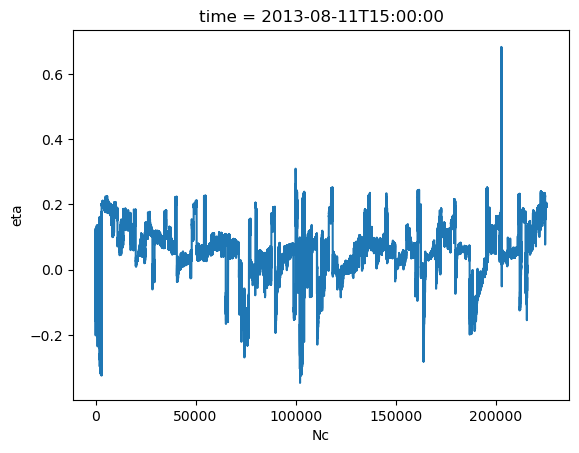

In [20]:
#ds.eta.isel(time=1000).plot()
ds.eta.isel(time=1000).plot()

In [21]:
def _grad_block(da):
    
    # defer projection here such that workload in on workers
    op = nwa.load_grd()
    op["cells"] = op.cells.where( op.cells!=999999, other=-999999 )
    op.suntans.Nk = np.ones(op.Nc.size)
    #
    nwa.project(op)

    def _grad_np(v):
        return op.suntans.calc_grad(v)
    
    gx, gy = xr.apply_ufunc(_grad_np, da,
                            input_core_dims=(["Nc"],),  #["Nc", "Np", "numsides"]
                            output_core_dims=[["Nc"], ["Nc"]], 
                            output_dtypes=(float, float),
                            vectorize=True,
                           )
    ds = xr.merge([gx.rename("d"+da.name+"dx"), gy.rename("d"+da.name+"dy")])
    
    return ds

def grad(da):
    """ compute spatial gradients """
    
    out = xr.merge([da.rename("d"+da.name+"dx"), da.rename("d"+da.name+"dy")])
    ds = da.map_blocks(_grad_block, template=out)
    
    return ds

In [22]:
ds_grad = xr.merge([grad(ds[v]) for v in ["eta", "uc", "vc", "temp"]])

In [23]:
# rechunk
ds_grad = ds_grad.chunk(dict(time=745, Nc=2000)).persist()

In [24]:
zarr = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_gradients")

if low:
    zarr = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_low_gradients")

ds_grad.to_zarr(zarr, mode="w")

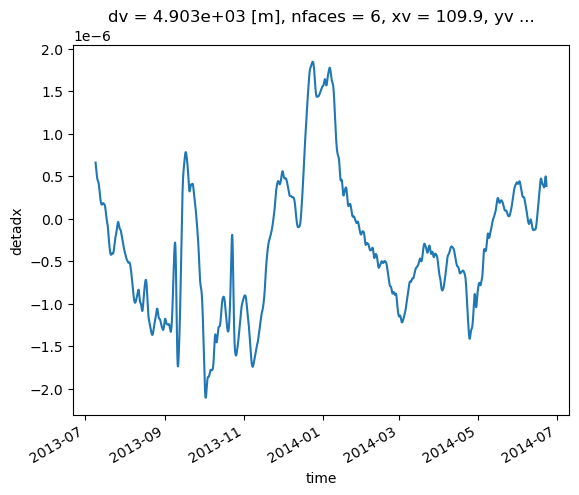

In [25]:
ds_grad.detadx.isel(Nc=100).plot()

---
## make some plots

In [3]:
ds, grd = nwa.load_surf()

#zarr = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_low")
#ds = xr.open_zarr(zarr)
#ds = ds.assign_coords(**grd)

In [4]:
# reload
zarr = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_gradients")
dsg = xr.open_zarr(zarr)

zarr = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_low_gradients")
dsg_low = xr.open_zarr(zarr)

In [6]:
# select snapshot
it = 1000
_ds = dsg.isel(time=it).compute()
_ds_low = dsg_low.isel(time=it).compute()

da = (_ds["dvcdx"] - _ds["ducdy"])/pin.geo.coriolis(_ds.yv)
da_low = (_ds_low["dvcdx"] - _ds_low["ducdy"])/pin.geo.coriolis(_ds.yv)

t = str(da.time.dt.strftime("%Y/%m/%d %H:%M").values)

Changing the _FillValue from -999999 to 999999


/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting

Text(0.5, 1.0, 'low - relative vorticity / f, t:2013/08/11 15:00')

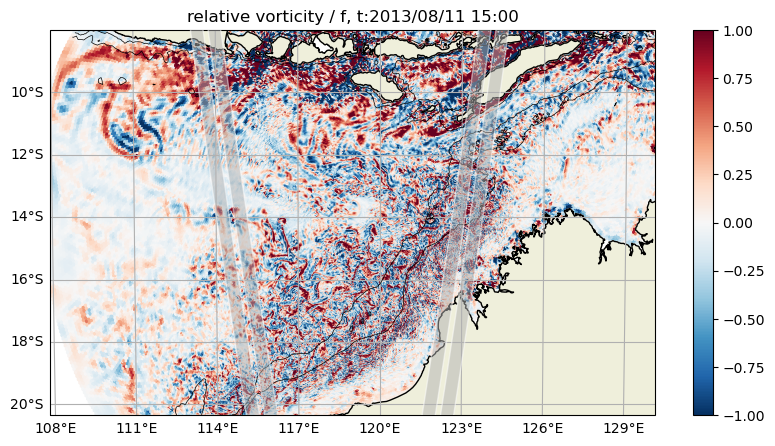

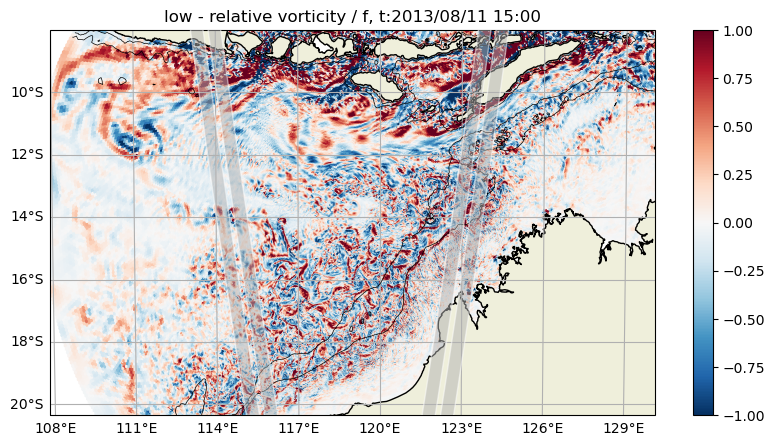

In [7]:
zoom = "large"

fig, ax = nwa.map_init(zoom, bathy=(grd, ds))
_, _, poly, cbar = grd.suntans.plotcelldata(da, cmap='RdBu_r', vmin=-1., vmax=1., crs=crs)
ax.set_title("relative vorticity / f, t:"+t)

fig, ax = nwa.map_init(zoom, bathy=(grd, ds))
_, _, poly, cbar = grd.suntans.plotcelldata(da_low, cmap='RdBu_r', vmin=-1., vmax=1., crs=crs)
ax.set_title("low - relative vorticity / f, t:"+t)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting

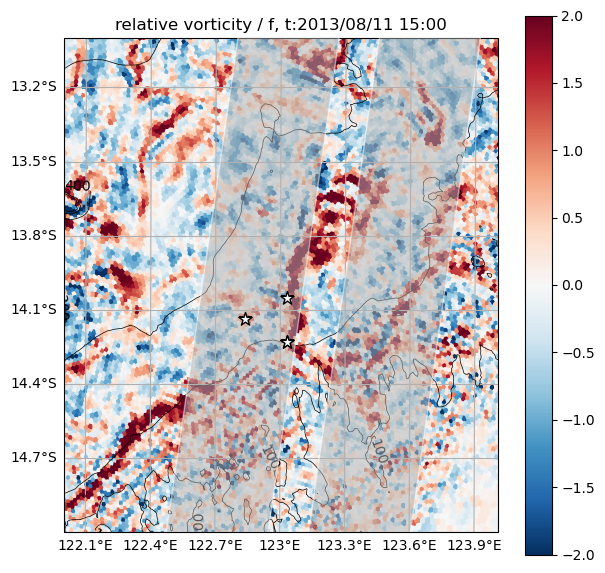

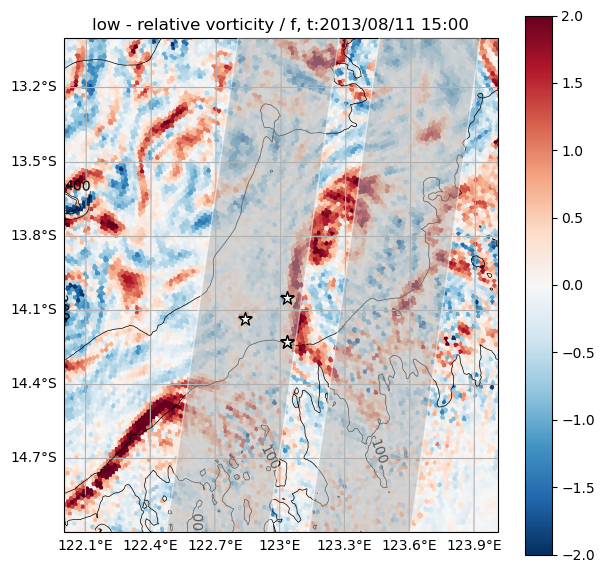

In [8]:
zoom = "cp"

vmax=2.

fig, ax = nwa.map_init(zoom, bathy=(grd, ds))
_, _, poly, cbar = grd.suntans.plotcelldata(da, cmap='RdBu_r', vmin=-vmax, vmax=vmax, crs=crs)
ax.set_title("relative vorticity / f, t:"+t)
nwa.plot_moorings(ax, zorder=30, s=100)

fig, ax = nwa.map_init(zoom, bathy=(grd, ds))
_, _, poly, cbar = grd.suntans.plotcelldata(da_low, cmap='RdBu_r', vmin=-vmax, vmax=vmax, crs=crs)
ax.set_title("low - relative vorticity / f, t:"+t)
nwa.plot_moorings(ax, zorder=30, s=100)

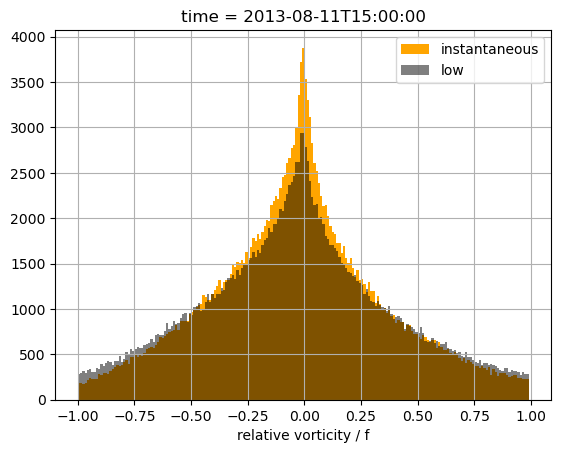

In [13]:
fig, ax = plt.subplots(1,1)
da_low.plot.hist(ax=ax, bins=np.arange(-1,1,.01), color="orange", label="instantaneous");
da.plot.hist(ax=ax, bins=np.arange(-1,1,.01), color="k", alpha=.5, label="low");
#ax.set_xscale("log")
#ax.set_yscale("log")
ax.grid()
ax.set_xlabel("relative vorticity / f")
ax.legend()

In [14]:
da.std()

<xarray.DataArray ()>
array(0.70476673)
Coordinates:
    time     datetime64[ns] 2013-08-11T15:00:00

In [15]:
da_low.std()

<xarray.DataArray ()>
array(0.55089626)
Coordinates:
    time     datetime64[ns] 2013-08-11T15:00:00

---

## old keep for records

This didn't work well for unknown reasons

In [25]:
def _grad(v):
    # defer projection here such that workload in on workers
    #op = nwa.load_grd()
    #op["cells"] = op.cells.where( op.cells!=999999, other=-999999 )
    #op.suntans.Nk = np.ones(ds.Nc.size)
    #
    nwa.project(op)
    return op.suntans.calc_grad(v)

def grad(da):
    """ compute """

    #da = da.chunk(dict(Nc=-1))
    # op is rechunked outsize
    
    gx, gy = xr.apply_ufunc(_grad, da,
                            input_core_dims=(["Nc"],),  #["Nc", "Np", "numsides"]
                            output_core_dims=[["Nc"], ["Nc"]], 
                            output_dtypes=(float, float),
                            dask="parallelized", vectorize=True,
                           )

    gx = gx.rename("d"+da.name+"dx")
    gy = gy.rename("d"+da.name+"dy")

    #scale_x = 111e3*np.cos(np.pi/180*da.yv)
    #scale_y = 111e3        
    #gx = gx.rename("d"+da.name+"dx")/scale_x
    #gy = gy.rename("d"+da.name+"dy")/scale_y
    
    return gx, gy

In [26]:
ds["detadx"], ds["detady"] = grad(ds.eta)
#
ds["dudx"], ds["dudy"] = grad(ds.uc)
ds["dvdx"], ds["dvdy"] = grad(ds.vc)
#ds["vorticity"] = ds["dvdx"] - ds["dudy"]
#ds["divergence"] = ds["dudx"] + ds["dvdy"]
#
ds["dtempdx"], ds["dtempdy"] = grad(ds.temp)

ds_grad = ds.drop(["eta", "temp", "uc", "vc"])

---

In [13]:
cluster.close()